In [1]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import plot_loss
from torch import optim
from tqdm.notebook import trange

from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer


2023-04-20 14:24:59.495444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 14:25:00.836395: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/LHAPDF/lib:/opt/MG5_aMC_v3_4_1/lib:/.singularity.d/libs
2023-04-20 14:25:00.836836: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/LHAPDF/lib:/opt/MG5_aMC_v3_4_1/lib:/.singularity.d/libs
2023-0

In [5]:
dataset = DatasetCombined("../../dataset/v7/")
batch_size = 512

# Read data
dataiterator = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

jets file already exists
lepton_reco file already exists
met file already exists
boost file already exists
partons file already exists
lepton_partons file already exists
boost file already exists
H_thad_tlep_ISR file already exists
H_thad_tlep_ISR_cartesian file already exists
tensor([], size=(0, 10))


In [ ]:
(mask_partons, data_partons, 
mask_lepton_partons, data_lepton_partons, 
mask_boost_parton, data_boost_parton, 
data_intermediate, data_intermediate_cartesian,
data_ps,  mask_lepton, data_lepton, mask_jets,
data_jets,mask_met, data_met,
mask_boost_reco,data_boost_reco) =  next(iter(dataiterator))

In [ ]:
# Initialize Transformer Layer
transformer = ConditioningTransformerLayer(jets_features=data_jets.size(2), 
                                           lepton_features=data_lepton.size(2), 
                                           out_features=32, nhead=8, no_layers=3)

# Obtain conditional_input from transformer (pass batches and masks to `forward` method)
conditional_input = transformer.forward(data_jets, data_lepton, data_met,
                                        data_boost_reco, mask_jets, 
                                        mask_lepton, mask_met, mask_boost_reco)

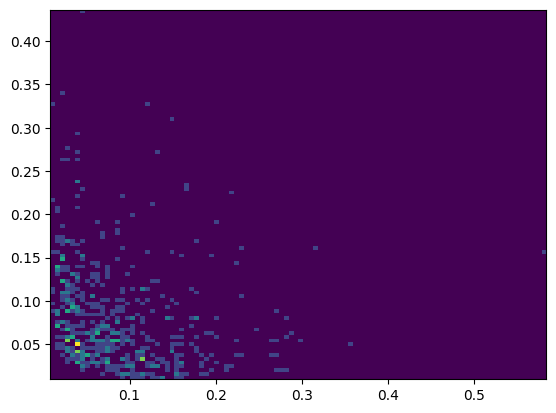

In [5]:
plt.hist2d(conditional_input.detach().numpy()[:, 0], 
           conditional_input.detach().numpy()[:, 1], bins=100) ;

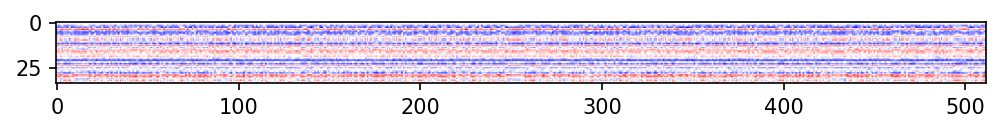

In [6]:
plt.figure(figsize=(8,8), dpi=150)
plt.imshow(conditional_input.T.detach().numpy(), cmap="bwr")

In [27]:
data_ps.shape

torch.Size([512, 10])

# Setup the flow

In [5]:
import zuko

In [6]:
from zuko.flows import TransformModule, SimpleAffineTransform
from zuko.distributions import BoxUniform

In [7]:
def build_flow(nfeatures=10, ncond=32, ntransforms=4, hidden_mlp=[32]*3, bins=8, randperm=False, autoregressive=True):
    
    flow = zuko.flows.NSF(features=nfeatures,
                          context=ncond, 
                          transforms=ntransforms, 
                          bins=bins, 
                          hidden_features=hidden_mlp, 
                          randperm=randperm,
                          base=BoxUniform,
                          base_args=[torch.ones(nfeatures)*(-1),torch.ones(nfeatures)], 
                          univariate_kwargs={"bound": 1 }, # Keeping the flow in the [-1,1] box.
                          passes= 2 if not autoregressive else nfeatures)

    flow.transforms.insert(0, SimpleAffineTransform(0*torch.ones(nfeatures),1*torch.ones(nfeatures),
                                                 -1*torch.ones(nfeatures), 1*torch.ones(nfeatures)))
    
    return flow

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
fl1 = build_flow(nfeatures=10,
                 ncond=34, 
                 ntransforms=6, 
                 hidden_mlp=[64]*3, 
                 bins=10, 
                 autoregressive=False)

cond_transformer = ConditioningTransformerLayer(jets_features=data_jets.size(2), 
                                           lepton_features=data_lepton.size(2), 
                                           out_features=32, nhead=8, no_layers=3)

print(f"parameters, {count_parameters(fl1)}")

NameError: name 'data_jets' is not defined

In [10]:
ps_samples = fl1(conditional_input).sample((100, ))

NameError: name 'conditional_input' is not defined

In [13]:
%%timeit
ps_samples = fl1(conditional_input).sample((1, ))

39.5 ms ± 3.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%%timeit
ps_prob = fl1(conditional_input).log_prob(data_ps)

26.6 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Training loop

In [ ]:
nepochs = 50
lr_init = 0.0001
batch_size = 512

In [35]:
dataset = DatasetCombined("../../dataset/v7/")
# Read data
dataiterator = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

jets file already exists
lepton_reco file already exists
met file already exists
boost file already exists
partons file already exists
lepton_partons file already exists
boost file already exists
H_thad_tlep_ISR file already exists
H_thad_tlep_ISR_cartesian file already exists


In [36]:
cond_transformer = ConditioningTransformerLayer(jets_features=data_jets.size(2), 
                                           lepton_features=data_lepton.size(2), 
                                           out_features=16, nhead=1, no_layers=4)

flow = build_flow(nfeatures=10,
                 ncond=18, 
                 ntransforms=6, 
                 hidden_mlp=[128]*2, 
                 bins=16, 
                 autoregressive=True)


optimizer = optim.Adam(list(flow.parameters()) +list(cond_transformer.parameters()) , lr=lr_init)

#decay = 0.01
#fcn = lambda step: 1./(1. + decay*step)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=fcn)

plotter = plot_loss.LossPlotter(["loss_epoch","loss"])

print(f"parameters flow:{count_parameters(flow)}, parameters conditioner: {count_parameters(cond_transformer)}")

parameters flow:485144, parameters conditioner: 275293


In [37]:
flow

NSF(
  (transforms): ModuleList(
    (0): SimpleAffineTransform([tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])] -> [tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])])
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=16)
      (order): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=28, out_features=128, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=128, out_features=470, bias=True)
      )
    )
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=16)
      (order): [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=28, out_features=128, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=128, out

In [38]:
len(dataiterator)

1113

In [39]:
torch.autograd.set_detect_anomaly(True)

In [ ]:
for e in trange(0, nepochs, desc="Epoch"):
    
    sum_loss = 0.
    N = 0
    t = trange(0, len(dataiterator), batch_size, desc="Batch")
    
    for i, data in enumerate(dataiterator):
        (mask_partons, data_partons, 
        mask_lepton_partons, data_lepton_partons, 
        mask_boost_parton, data_boost_parton, 
        data_intermediate, data_intermediate_cartesian,
        data_ps, data_ps_detinvjac, mask_lepton, data_lepton, mask_jets,
        data_jets,mask_met, data_met,
        mask_boost_reco,data_boost_reco) =  data
    
        optimizer.zero_grad()
        
        cond_X = cond_transformer(data_jets, data_lepton, data_met,
                                        data_boost_reco, mask_jets, 
                                        mask_lepton, mask_met, mask_boost_reco)
        
        logp_g = flow(cond_X).log_prob(data_ps) + data_ps_detinvjac.log() # Be careful, we are probably missing the rambo jacobian
        
        logp_g = torch.nan_to_num(logp_g, posinf=4, neginf=-5)
        
        loss =  -logp_g.mean()
        #print(logp_g.isnan().sum(),logp_g.isinf().sum(), loss.item(),  logp_g)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(flow.parameters(), 0.1)
        torch.nn.utils.clip_grad_norm_(cond_transformer.parameters(), 0.1)
        optimizer.step()     
        sum_loss += loss.item()

        plotter.on_epoch_end({"loss": loss.item()})
        #t.set_description(f"{loss.item():.4f}", refresh=True)
    plotter.on_epoch_end({"loss_epoch":sum_loss/N})
        
    
#     with torch.no_grad():
#         out = flow(Y_scaled[0:30000]).sample((1, )).squeeze(0)
#         plt.hist2d(out[:,0].numpy(), 
#                    Y_scaled[0:30000,0].numpy(), 
#                    bins=100,cmap="inferno", cmin=1, norm=LogNorm() );
#         plt.xlabel("Pz generated")
#         plt.ylabel("Pz reco (conditioning)")
        
#         # plt.hist2d(out[:,0].numpy(), out[:,1].numpy(),
#         #    bins=100, cmap="inferno", cmin=1, norm=LogNorm());
        
#         plt.show()
#         plt.close()


In [36]:
-logp_g.mean()

tensor(-1.1221, grad_fn=<NegBackward0>)

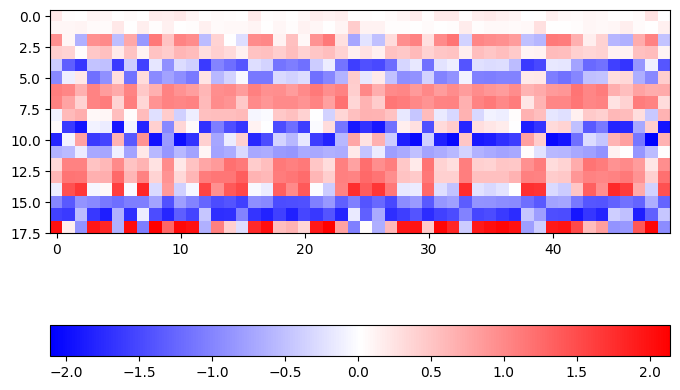

In [41]:
cond_X = cond_transformer(data_jets, data_lepton, data_met,
                                        data_boost_reco, mask_jets, 
                                        mask_lepton, mask_met, mask_boost_reco)
        
plt.figure(figsize=(8,8), dpi=100)
plt.imshow(cond_X[:50,:].T.detach().numpy(), cmap="bwr")
plt.colorbar(location="bottom")

In [42]:
(mask_partons, data_partons, 
        mask_lepton_partons, data_lepton_partons, 
        mask_boost_parton, data_boost_parton, 
        data_intermediate, data_intermediate_cartesian,
        data_ps,  mask_lepton, data_lepton, mask_jets,
        data_jets,mask_met, data_met,
        mask_boost_reco,data_boost_reco) =  data
    

cond_X = cond_transformer(data_jets, data_lepton, data_met,
                                        data_boost_reco, mask_jets, 
                                        mask_lepton, mask_met, mask_boost_reco)

In [43]:
ps_new = flow(cond_X).sample((50,))

In [44]:
data_ps.shape

torch.Size([512, 10])

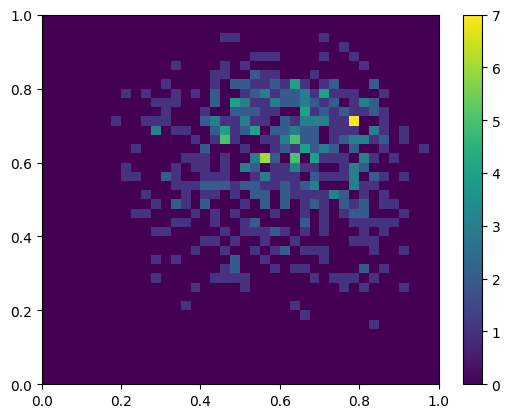

In [75]:
plt.hist2d(data_ps[:,8].numpy(), 
           data_ps[:,9].numpy(), 
           bins=40, range=((0,1),(0,1)));
plt.colorbar()

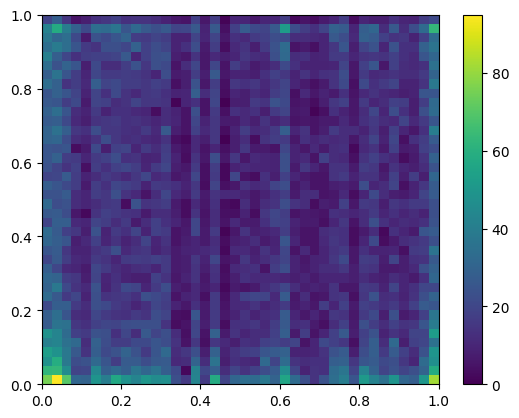

In [65]:
plt.hist2d(data_ps[:,1].unsqueeze(0).tile(50,1,1).flatten().numpy(), 
           ps_new[:,:,1].flatten().numpy(), 
           bins=40, range=((0,1),(0,1)));
plt.colorbar()

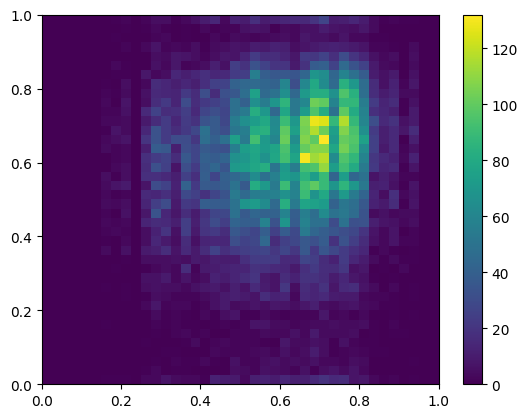

In [45]:
plt.hist2d(data_ps[:,-1:].unsqueeze(0).tile(50,1,1).flatten().numpy(), 
           ps_new[:,:,-1:].flatten().numpy(), 
           bins=40, range=((0,1),(0,1)));
plt.colorbar()

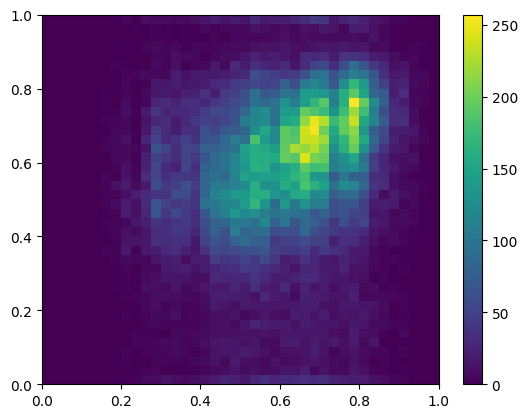

In [46]:
plt.hist2d(data_ps[:,-2:].unsqueeze(0).tile(50,1,1).flatten().numpy(), 
           ps_new[:,:,-2:].flatten().numpy(), 
           bins=40, range=((0,1),(0,1)));
plt.colorbar()

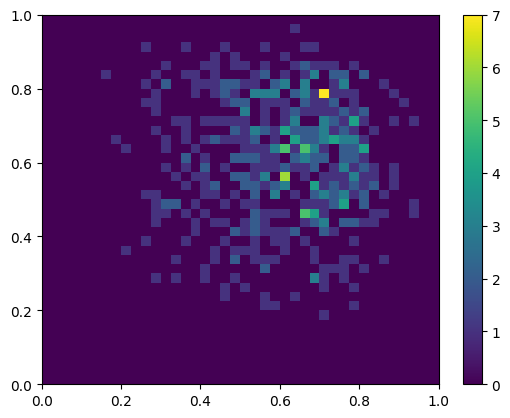

In [47]:
plt.hist2d(data_ps[:,-1].flatten().numpy(), 
           data_ps[:,-2].flatten().numpy(), 
           bins=40, range=((0,1),(0,1)));
plt.colorbar()

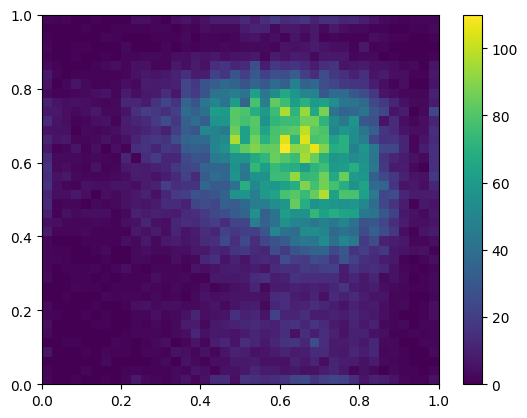

In [48]:
plt.hist2d(ps_new[:,:,-1].flatten().numpy(), 
           ps_new[:,:,-2].flatten().numpy(), 
           bins=40, range=((0,1),(0,1)));
plt.colorbar()

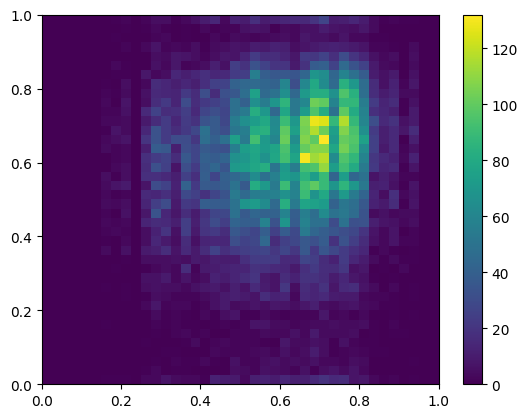

In [62]:
plt.hist2d(data_ps[:,9].unsqueeze(0).tile(50,1,1).flatten().numpy(), 
           ps_new[:,:,9].flatten().numpy(), 
           bins=40, range=((0,1),(0,1)));
plt.colorbar()

(array([ 104.,  293.,  474.,  652.,  715.,  822.,  846.,  945., 1004.,
        1043., 1214., 1249., 1264., 1320., 1303., 1473., 1533., 1542.,
        1653., 1702., 1773., 1759., 1888., 1946., 1988., 2043., 2113.,
        2355., 2329., 2489., 2564., 2623., 2743., 2911., 3020., 3277.,
        3281., 3482., 3601., 3940., 4066., 4415., 4576., 4914., 5171.,
        5361., 5712., 6011., 6350., 6770., 6924., 6611., 6283., 6035.,
        5586., 5459., 5099., 4743., 4449., 4318., 3960., 3755., 3529.,
        3423., 3214., 3028., 2860., 2767., 2621., 2607., 2496., 2446.,
        2337., 2186., 2180., 2022., 1920., 1864., 1765., 1743., 1772.,
        1686., 1560., 1545., 1379., 1397., 1376., 1290., 1151., 1108.,
        1035., 1023.,  878.,  838.,  753.,  684.,  624.,  486.,  421.,
         142.]),
 array([-1.00027293e+00, -9.80263043e-01, -9.60253153e-01, -9.40243262e-01,
        -9.20233372e-01, -9.00223482e-01, -8.80213591e-01, -8.60203701e-01,
        -8.40193810e-01, -8.20183920e-01, -8.00174

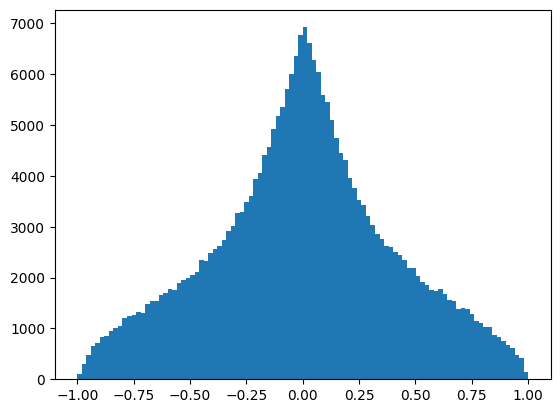

In [50]:
plt.hist((data_ps-ps_new).flatten(), bins=100)